Fully Homomorphically Encrypted Fashion-MNIST CNN Example
=========================================================

- This example will download Fashion-MNIST (a drop in replacement for MNIST)
- Prepare Fashion-MNIST
- Train a very basic CNN on Fashion-MNIST in plaintext
- Infer using the testing set using both plaintexts and cyphertexts for comparison

.. warning:

    The encrypted forward pass is VERY RAM HUNGRY! Keep a close eye on your RAM usage in case it exceeds your machines capabilities. In some scenarios it may be desirable to have a SWAP partition on the fastest storage you have avaliable. We are working on getting the RAM usage down! FHE on anything is very space and compute intensive, but we do have inefficiencies we could minimise too.

# Basic Setup

In [1]:
import sys
!{sys.executable} -m pip install pyvis seaborn

In [2]:
import os
import requests
import zipfile
import logging
import time
import datetime
import copy
import seaborn as sns
import pandas as pd
logging.basicConfig(level=logging.ERROR)
sns.set_theme(style="whitegrid")
# logging.basicConfig(level=logging.DEBUG)

# Display our pre-existing findings

(Skip this section if you have deleted our existing results and are thus starting from scratch)

In this section we will output some graphs to show our existing findings in fashion_MNIST_results.csv. This Jupyter notebook will append more results when run to this CSV file so you can also use this to show your new results when you run this file.

In [3]:
csv_path = "fashion_MNIST_results.csv"
all_results = pd.read_csv(csv_path, index_col=False)
all_results

,accuracy,training_time,plain_inference_time,datetime,y_hat_sample,y_sample,inference_size,activation,time_taken,is_plaintext,is_cyphertext,session
0,0.6511,437.602509,35.014159,2021-10-12 10:48:08.505291,"[4, 4, 2, 1, 7, 7, 8, 4, 4, 1, 7, 7, 7, 8, 1, ...","[4, 4, 2, 1, 5, 7, 8, 4, 4, 1, 5, 7, 7, 8, 1, ...",10000,ReLU,NaN,NaN,NaN,NaN
1,0.5576,434.175892,34.966154,2021-10-12 12:59:45.888788,"[4, 4, 4, 1, 7, 7, 8, 3, 4, 1, 7, 7, 7, 8, 1, ...","[4, 4, 2, 1, 5, 7, 8, 4, 4, 1, 5, 7, 7, 8, 1, ...",10000,ReLU,NaN,NaN,NaN,NaN
2,0.2318,434.045423,34.940857,2021-10-12 13:08:06.098759,"[1, 5, 5, 1, 5, 7, 5, 5, 1, 1, 5, 5, 7, 5, 1, ...","[4, 4, 2, 1, 5, 7, 8, 4, 4, 1, 5, 7, 7, 8, 1, ...",10000,ReLU,NaN,NaN,NaN,NaN
3,0.6552,440.584696,34.895064,2021-10-12 13:28:06.498966,"[4, 4, 2, 1, 7, 9, 8, 1, 4, 1, 7, 7, 7, 8, 1, ...","[4, 4, 2, 1, 5, 7, 8, 4, 4, 1, 5, 7, 7, 8, 1, ...",10000,ReLU,NaN,NaN,NaN,NaN
4,0.2605,435.607623,34.508964,2021-10-12 13:37:04.358536,"[1, 1, 5, 1, 7, 7, 0, 1, 2, 1, 7, 5, 7, 5, 1, ...","[4, 4, 2, 1, 5, 7, 8, 4, 4, 1, 5, 7, 7, 8, 1, ...",10000,ReLU,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.6261,919.977976,NaN,2022-07-03 17:52:24.954812,"[4, 4, 4, 1, 7, 5, 8, 4, 4, 1, 5, 7, 5, 8, 1, ...","[0, 1, 2, 2, 3, 2, 8, 6, 5, 0, 3, 4, 4, 6, 8, ...",10000,Sigmoid,75.412392,1.0,0.0,zi9TBx
63,0.6362,940.418993,NaN,2022-07-03 23:29:37.320797,"[2, 4, 2, 3, 7, 9, 8, 4, 2, 3, 7, 7, 9, 2, 3, ...","[0, 1, 2, 2, 3, 2, 8, 6, 5, 0, 3, 4, 4, 6, 8, ...",10000,Sigmoid,74.788434,1.0,0.0,xVsp6w
64,0.6144,944.458827,NaN,2022-07-03 23:53:35.181248,"[4, 4, 6, 1, 5, 7, 8, 4, 4, 1, 7, 7, 7, 8, 1, ...","[0, 1, 2, 2, 3, 2, 8, 6, 5, 0, 3, 4, 4, 6, 8, ...",10000,Sigmoid,81.623405,1.0,0.0,VUg5Jg
65,0.6434,951.831432,NaN,2022-07-04 00:17:16.822525,"[4, 4, 6, 1, 7, 5, 8, 4, 4, 1, 5, 7, 5, 8, 1, ...","[0, 1, 2, 2, 3, 2, 8, 6, 5, 0, 3, 4, 4, 6, 8, ...",10000,Sigmoid,76.656483,1.0,0.0,y9h5XJ


A few minor fixes to the table from older versions

In [4]:
fill_dict = {"activation": "ReLU", "is_plaintext": 1.0, "is_cyphertext": 0, }
all_results = all_results.fillna(value=fill_dict)
try:
    all_results["time_taken"].fillna(all_results["plain_inference_time"], inplace=True) # move values from old column to new
    del all_results["plain_inference_time"]
except KeyError:
    pass # ok not dealing with an old version
all_results.loc[all_results["is_plaintext"] == 1, "dtype"] = "plaintext"
all_results = all_results.fillna(value={"dtype": "cyphertext"})
all_results

,accuracy,training_time,datetime,y_hat_sample,y_sample,inference_size,activation,time_taken,is_plaintext,is_cyphertext,session,dtype
0,0.6511,437.602509,2021-10-12 10:48:08.505291,"[4, 4, 2, 1, 7, 7, 8, 4, 4, 1, 7, 7, 7, 8, 1, ...","[4, 4, 2, 1, 5, 7, 8, 4, 4, 1, 5, 7, 7, 8, 1, ...",10000,ReLU,35.014159,1.0,0.0,NaN,plaintext
1,0.5576,434.175892,2021-10-12 12:59:45.888788,"[4, 4, 4, 1, 7, 7, 8, 3, 4, 1, 7, 7, 7, 8, 1, ...","[4, 4, 2, 1, 5, 7, 8, 4, 4, 1, 5, 7, 7, 8, 1, ...",10000,ReLU,34.966154,1.0,0.0,NaN,plaintext
2,0.2318,434.045423,2021-10-12 13:08:06.098759,"[1, 5, 5, 1, 5, 7, 5, 5, 1, 1, 5, 5, 7, 5, 1, ...","[4, 4, 2, 1, 5, 7, 8, 4, 4, 1, 5, 7, 7, 8, 1, ...",10000,ReLU,34.940857,1.0,0.0,NaN,plaintext
3,0.6552,440.584696,2021-10-12 13:28:06.498966,"[4, 4, 2, 1, 7, 9, 8, 1, 4, 1, 7, 7, 7, 8, 1, ...","[4, 4, 2, 1, 5, 7, 8, 4, 4, 1, 5, 7, 7, 8, 1, ...",10000,ReLU,34.895064,1.0,0.0,NaN,plaintext
4,0.2605,435.607623,2021-10-12 13:37:04.358536,"[1, 1, 5, 1, 7, 7, 0, 1, 2, 1, 7, 5, 7, 5, 1, ...","[4, 4, 2, 1, 5, 7, 8, 4, 4, 1, 5, 7, 7, 8, 1, ...",10000,ReLU,34.508964,1.0,0.0,NaN,plaintext
...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.6261,919.977976,2022-07-03 17:52:24.954812,"[4, 4, 4, 1, 7, 5, 8, 4, 4, 1, 5, 7, 5, 8, 1, ...","[0, 1, 2, 2, 3, 2, 8, 6, 5, 0, 3, 4, 4, 6, 8, ...",10000,Sigmoid,75.412392,1.0,0.0,zi9TBx,plaintext
63,0.6362,940.418993,2022-07-03 23:29:37.320797,"[2, 4, 2, 3, 7, 9, 8, 4, 2, 3, 7, 7, 9, 2, 3, ...","[0, 1, 2, 2, 3, 2, 8, 6, 5, 0, 3, 4, 4, 6, 8, ...",10000,Sigmoid,74.788434,1.0,0.0,xVsp6w,plaintext
64,0.6144,944.458827,2022-07-03 23:53:35.181248,"[4, 4, 6, 1, 5, 7, 8, 4, 4, 1, 7, 7, 7, 8, 1, ...","[0, 1, 2, 2, 3, 2, 8, 6, 5, 0, 3, 4, 4, 6, 8, ...",10000,Sigmoid,81.623405,1.0,0.0,VUg5Jg,plaintext
65,0.6434,951.831432,2022-07-04 00:17:16.822525,"[4, 4, 6, 1, 7, 5, 8, 4, 4, 1, 5, 7, 5, 8, 1, ...","[0, 1, 2, 2, 3, 2, 8, 6, 5, 0, 3, 4, 4, 6, 8, ...",10000,Sigmoid,76.656483,1.0,0.0,y9h5XJ,plaintext


## Plot the performance of the neural networks by activation function

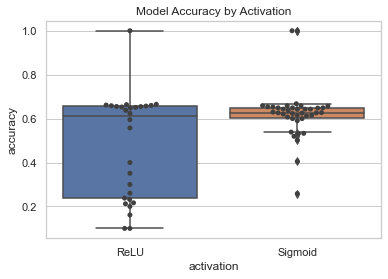

In [5]:
ax = sns.boxplot(y="accuracy", x="activation", data=all_results)
ax = sns.swarmplot(y="accuracy", x="activation", data=all_results, color=".25")
ax.set(title="Model Accuracy by Activation")
fig = ax.get_figure()
fig.savefig("sphira-fashion-mnist-performance.png") 

## Plot the time taken by plaintexts and cyphertexts

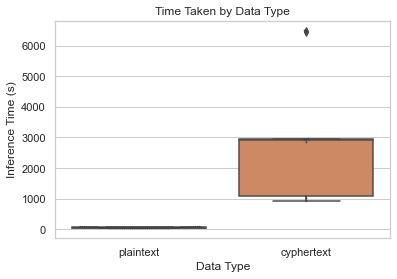

In [6]:
ax = sns.boxplot(y="time_taken", x="dtype", data=all_results)
ax = sns.swarmplot(y="time_taken", x="dtype", data=all_results, color=".25", size=2)
ax.set(title="Time Taken by Data Type", ylabel="Inference Time (s)", xlabel="Data Type")
fig = ax.get_figure()
fig.savefig("sphira-fashion-mnist-inference-time.png") 

Download Fashion-MNIST
----------------------

- Get Fashion-MNIST as a zipped up set of CSVs
- Unizp Fashion-MNIST

In [7]:
cwd = os.getcwd() # current working directory
print(cwd)

/Users/devharsh/Downloads/python-fhez/examples


In [8]:
data_dir = os.path.join(cwd, "datasets")
if os.path.exists(data_dir):
    pass
else:
    os.mkdir(data_dir)
print(data_dir)

/Users/devharsh/Downloads/python-fhez/examples/datasets


In [9]:
mnist_zip = os.path.join(data_dir, "mnist.zip")
if os.path.exists(mnist_zip):
    print("Skipping mnist download")
else:
    print("Downloading Fashion-MNIST")
    mnist_url = "http://nextcloud.deepcypher.me/s/wjLa6YFw8Bcbra9/download"
    r = requests.get(mnist_url, allow_redirects=True, verify=False)
    with open(mnist_zip, "wb") as f:
        f.write(r.content)

Skipping mnist download


In [10]:
unzip_dir = os.path.join(data_dir, "mnist")
if os.path.exists(unzip_dir):
    pass
else:
    os.mkdir(unzip_dir)
with zipfile.ZipFile(mnist_zip, "r") as zip_ref:
    zip_ref.extractall(unzip_dir)

"Wrangle"/ prepare Fashion-MNIST
--------------------------------

- Read in the Fashion-MNIST CSVs
- Split training and testing features (x) from target (y)
- Normalise x and y (in the range 0-1 to prevent infinite numbers when using our approximations)

In [11]:
import pandas as pd
import numpy as np
import tqdm

In [12]:
train_file = os.path.join(unzip_dir, "fashion-mnist_train.csv") 
test_file = os.path.join(unzip_dir, "fashion-mnist_test.csv")
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
# train

In [13]:
train_y = train.iloc[:, 0]
train_x = train.iloc[:, 1:]/255 # normalise to 0-1 preventing explosion
test_x = test.iloc[:, 1:]/255 # normalise to 0-1 preventing explosion
test_y = test.iloc[:, 0]
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()
print(train_x.shape)
print(train_y.shape)

(60000, 784)
(60000,)


In [14]:
# train_x[0]

In [15]:
train_x[0].shape

(784,)

Define Neural Network
---------------------

- Use [Networkx](https://networkx.org/) to construct a **multi-directed-graph** as a neural network
- Nodes for this graph are abstractions of neural network components with forward, backward (backpropogation), update (weight update/ optimisation), and costs (computational depth of traversal to the node)
- We use Nodes that inherit from the abstract base class [fhez.nn.graph.node.Node](https://python-fhez.readthedocs.io/en/latest/nodes/node.html#node) so if you need to define your own type of node inherit from this to match the API the network traverser expects

In [16]:
import networkx as nx
from fhez.nn.graph.prefab import sphira
from fhez.nn.activation.sigmoid import Sigmoid
graph = sphira()
print(graph) # you can modify this graph like any other networkx graph using our existing/ ready made nodes like adding a new CNN layer for instance

MultiDiGraph with 108 nodes and 151 edges


In [17]:
# # optionally modify the graph
# # here we replace RELU with sigmoid activation for comparison only, ReLU is almost certainly better
from fhez.nn.activation.sigmoid import Sigmoid
graph.nodes(data=True)["CNN-RELU"]["node"] = Sigmoid()
print(graph.nodes(data=True)["CNN-RELU"])
for i in range(10):
    graph.nodes(data=True)["Dense-RELU-{}".format(i)]["node"] = Sigmoid()
    print(graph.nodes(data=True)["Dense-RELU-{}".format(i)])


{'group': 1, 'node': <fhez.nn.activation.sigmoid.Sigmoid object at 0x12b6b2ee0>}
{'group': 2, 'node': <fhez.nn.activation.sigmoid.Sigmoid object at 0x12b6949d0>}
{'group': 2, 'node': <fhez.nn.activation.sigmoid.Sigmoid object at 0x12b6b2fd0>}
{'group': 2, 'node': <fhez.nn.activation.sigmoid.Sigmoid object at 0x12b6b2ca0>}
{'group': 2, 'node': <fhez.nn.activation.sigmoid.Sigmoid object at 0x12b683c10>}
{'group': 2, 'node': <fhez.nn.activation.sigmoid.Sigmoid object at 0x12b6836d0>}
{'group': 2, 'node': <fhez.nn.activation.sigmoid.Sigmoid object at 0x12b683a30>}
{'group': 2, 'node': <fhez.nn.activation.sigmoid.Sigmoid object at 0x12b683ac0>}
{'group': 2, 'node': <fhez.nn.activation.sigmoid.Sigmoid object at 0x12b683790>}
{'group': 2, 'node': <fhez.nn.activation.sigmoid.Sigmoid object at 0x12b6834c0>}
{'group': 2, 'node': <fhez.nn.activation.sigmoid.Sigmoid object at 0x12b6c3040>}


Visualise the graph
-------------------

In [18]:
import copy
def strip(graph):
    g = copy.deepcopy(graph)
    for node in g.nodes(data=True):
        try:
            # node[1]["title"] = "{}:\n{}".format(type(node[1]["node"]), repr(node[1]["node"]))
            del node[1]["node"]
        except KeyError:
            pass
    return g
    
print(graph)

MultiDiGraph with 108 nodes and 151 edges


In [19]:
from pyvis.network import Network
stripped = strip(graph)
print(stripped)

from pyvis.network import Network
net = Network('700px', '700px', bgcolor='#222222', font_color='white', notebook=True)
net.from_nx(stripped)
# net.show_buttons(filter_="physics")
net.show("graph.html")

MultiDiGraph with 108 nodes and 151 edges


Train Using Plaintext Data
--------------------------

- Instantiate our neural networks
- Compute the forward pass of our neural networks
- Compute the backward pass of our neural networks

I would like to stress that FHE is not a panacea.
You may be wondering, why dont we train the neural network using cyphertexts? The simple answer is, *where/ when do we stop?*
This statement refers to two *stops* in particular, when do we stop the training when we cannot see the loss, and where does the cyphertext *stop* for instance do we carry the cyphertext all the way through which means our neural network weights are encrypted.
The solution to the first *stop* is both simple but expensive, the answer is we compute the training-test divergence on the client side where the keys exist so that we can find the optimal *training stop* point but this requires us to have a continued connection to the client.
There are many answers to when we might figurativeley stop the cyphertext, but if privacy is of pivital concern then the only real answer is never, since any plaintext weights could be used in theorey to reconstruct the data that was used to train it, which means if we do the forward pass in cyphertext but do the backward pass in plaintext we dont gain any privacy since the data is then known to the data processor. However if we stick to cyphertexts throught all the way upto and including the weight update that means naturally when the weights are updated by the gradients which themselves come from the inputs thus all cyphertexts, that the weights after the first iteration of the network will become encrypted, taking *significantly* (orders of magnitude) longer to calculate since cyphertext + cyphertext operations take much longer even than cyphertext + plaintext calculations. This is not to mention the lack of compatibility of loss functions with FHE since many require some form of division which must be approximated.

Thus we think the optimal solution is actually transfer learning. Where you train on a similar dataset and try to transfer the understanding to a similar problem, but infer using cyphertexts only. That way privacy is maintained since the plaintext weights are untouched by the clients data, and we can still create encrypted inference albeit with lower accuracy, but not incurring the cyphertext-cyphertext cost of encrypted weights.

In [20]:
from fhez.nn.graph.utils import train, infer
from fhez.nn.loss.cce import CCE

In [21]:
# cnn = Layer_CNN(weights=( 1, 6, 6 ), stride=[ 1, 4, 4 ], bias=0)
# dense = None
# for cyphertext in row_encrypted_generator(data=train_x, shape=( 1, 28, 28 )):
#     cnn_acti = cnn.forward(cyphertext)
#     if dense is None:
#         dense = Layer_ANN(weights=(len(cnn_acti),), bias=0)
#     dense.forward(cnn_acti)

In [22]:
train_dict = {
        "x": [],
        "y": [],
    }

for i in zip(train_x, train_y):
    train_dict["x"].append(np.reshape(i[0], (28,28)))
    train_dict["y"].append(i[1])
    
# # for i in train_x:
# #     train_dict["x"].append(np.reshape(i, (28, 28)))
    
# print(train_y, type(train_y), train_y.shape)
# print(train_x, type(train_x), train_x.shape)

In [23]:
tt = time.time()
output = train(graph=graph, inputs=train_dict, batch_size=5, debug=False)
tt = time.time() - tt

Learn: 100%|████████████████████████████████████| 60000/60000 [14:45<00:00, 67.73it/s]


In [24]:
trained_graph = copy.deepcopy(graph)

now that a graph has been trained let us mark it with a unique session reference just so when we save it in the CSV it is easier to find

In [25]:
import random, string
session = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(6))
session

'lMIfP5'

In [26]:
output

{'y_hat': 7, 'Loss-CCE': 1.676673296675122}

Plaintext Inference
-------------------

- Find accuracy against testing set in plaintext space for comparison

In [27]:
test_dict = {
        "x": [],
        "y": [],
    }
for i in zip(test_x, test_y):
    test_dict["x"].append(np.reshape(i[0], (28,28)))
    test_dict["y"].append(i[1])
    
pi = time.time()
y_hats = infer(graph=graph, inputs={key:value for key,value in test_dict.items() if key in ["x"]})["y_hat"] 
pi = time.time() - pi

Infer: 100%|███████████████████████████████████| 10000/10000 [01:11<00:00, 139.79it/s]


In [28]:
sample=y_hats[20:40]
sample

[4, 4, 6, 1, 7, 5, 8, 4, 4, 1, 5, 7, 5, 8, 1, 6, 9, 6, 3, 3]

In [29]:
true_sample = test_dict["y"][:20]
true_sample

[0, 1, 2, 2, 3, 2, 8, 6, 5, 0, 3, 4, 4, 6, 8, 5, 6, 3, 6, 4]

In [30]:
accurates = np.where(np.isclose(y_hats, test_dict["y"]))
len(accurates[0])

5991

In [31]:
accuracy = len(accurates[0])/len(test_dict["y"])
print("Accuracy {}".format(accuracy))

Accuracy 0.5991


In [32]:
current_result = pd.DataFrame({"accuracy": [accuracy], 
                               "training_time": [tt], 
                               "time_taken": [pi], 
                               "datetime": [datetime.datetime.now()], 
                               "y_hat_sample": [sample], 
                               "y_sample": [true_sample], 
                               "inference_size": [len(test_dict["y"])],
                               "activation": ["Sigmoid"] if isinstance(graph.nodes(data=True)["CNN-RELU"]["node"], Sigmoid) else ["ReLU"],
                               "is_plaintext": [1],
                               "is_cyphertext": [0],
                               "session": [session]
                              })
try:
    all_results = pd.read_csv(csv_path, index_col=False)
    all_results = pd.concat([all_results, current_result])
except FileNotFoundError:
    all_results = current_result
all_results.to_csv(csv_path, index=False)

Not great, not terrible (3.6 roentgen). Absolute network performance can always be improved by using newer/ better architectures, and more epochs if it has not learnt what it can from the training set. we use a simple 1 CNN layer + 10 Dense layers + softmax into categorical cross entropy, there are much better architectures to use but we are concerned with the encryption here so we dont want to overcomplicate things. This is more of a means to an end of comparison.

Encrypted Inference
-------------------

- find accuracy against testing set again but this time in encrypted space

Parameterise Encoding/ Encryption and Create an Encrypted Generator
-------------------------------------------------------------------

- Parameterise our neural network graph encryption nodes
- Automatically set parameterisation using AtoFHE

This next cell shows how you would manually define parameters which you would then give to the encryption, decryption, and rotation nodes. However we do not need to do this any more thanks to our new autoHE which automatically parameterises the fully homomorphic nodes of "concern".

In [33]:
import seal
encryption_parameters = {
            "scheme": seal.scheme_type.ckks,
            "poly_modulus_degree": 8192*2,
            "coefficient_modulus":
                [45, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 45],
            "scale": pow(2.0, 30),
            "cache": True,
}

In [34]:
from fhez.nn.parametrisation.autofhe import autoHE # excuse the mixed spelling of parametrisation instead of parameterisation which we use everywhere else

In [35]:
encrypted_graph = copy.deepcopy(trained_graph)
groups = autoHE(graph=encrypted_graph, nodes=["x"])
groups
# # Generate Encrypted data peace-meal (as it can get very large)
# def row_encrypted_generator(data: np.ndarray, shape: tuple):
#     """Generate encrypted data of desired shape from rows."""
#     for row in data:
#         row = np.reshape(row, newshape=shape) / 255 # reshape to image shape and normalise between 0-1
#         yield ReArray(row, **encryption_parameters)

({'x': 0},
 [6],
 [ReArray({'_seed': ReSeal({'_scheme': <scheme_type.ckks: 2>, '_poly_modulus_degree': 16384, '_coefficient_modulus': [60, 40, 40, 40, 40, 40, 40, 60], '_scale': 1099511627776.0, '_cache': <fhez.recache.ReCache object at 0x12f8e3d00>, '_parameters': <seal.EncryptionParameters object at 0x12f8b69b0>, '_public_key': <seal.PublicKey object at 0x12bc52530>, '_private_key': <seal.SecretKey object at 0x12b735db0>, '_relin_keys': <seal.RelinKeys object at 0x12f8144b0>}), '_origin': {'shape': (1,), 'size': 1}})])

.. caution:

    This is where your RAM is gonna get swallowed up like Gazrilla in the black-hole at the centre of our universe!

In [36]:
mini_test_dict = {"x": test_dict["x"][:10]}

In [ ]:
ei = time.time()
y_hats = infer(graph=encrypted_graph, inputs=mini_test_dict)["y_hat"] 
ei = time.time() - ei

Infer:   0%|                                                   | 0/10 [00:00<?, ?it/s]

In [ ]:
accurates = np.where(np.isclose(y_hats, test_dict["y"][:len(y_hats)]))
accuracy = len(accurates[0])/len(y_hats)
# save info to csv file we used earlier
current_result = pd.DataFrame({"accuracy": [accuracy], 
                               "training_time": [tt], 
                               "time_taken": [ei], 
                               "datetime": [datetime.datetime.now()], 
                               "y_hat_sample": [y_hats],#[sample], 
                               "y_sample": [test_dict["y"][:len(y_hats)]], 
                               "inference_size": [len(y_hats)],
                               "activation": ["Sigmoid"] if isinstance(graph.nodes(data=True)["CNN-RELU"]["node"], Sigmoid) else ["ReLU"],
                               "is_plaintext": [0],
                               "is_cyphertext": [1],
                               "session": [session],
                              })
try:
    all_results = pd.read_csv(csv_path, index_col=False)
    all_results = all_results.append(current_result)
except FileNotFoundError:
    all_results = current_result
all_results.to_csv(csv_path, index=False)
all_results

There you have it, encrypted deep learning. Its slow, and heavy (as you would expect), but it works! Now in future we can work on reducing the footprint/ optimisation of FHE + its use. Now go run the top boxes again to plot your new results.